__check my algorithm with UCI data__:
 * _Wine_
 * _Glass_
 * _Sonar_
 * _Image_
 * _Iris_
 
__Assumptions__:
 * labels are integer numbers start from 0 -> [0,1,...]

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline

<b style="color:red">Load Wine DataSet</b>

In [98]:
wineData = pd.read_csv('data/wine.data',header=None)
wineY = wineData[0].apply(lambda x: x-1).values
wineX = wineData.drop(0,axis=1)
wineX = wineX.values

<b style="color:red">Load Glass Dataset</b>

In [99]:
glassData = pd.read_csv('data/glass.data',header=None)
glassY = glassData[10].apply(lambda x: x-1 if x<4 else x-2).values
glassX = glassData.drop([0,10],axis=1)
glassX = glassX.values

<b style="color:red">Load Sonar Dataset</b>

In [100]:
sonarData = pd.read_csv('data/sonar.data',header=None)
sonarY = (sonarData[60].apply(lambda x: 0 if x=='M' else 1)).values
sonarX = sonarData.drop(60,axis=1)
sonarX = sonarX.values

<b style="color:red">Load Image Dataset</b>

<b style="color:red">Load Iris Dataset</b>

In [101]:
def irisLableSet(name):
    names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    for i in xrange(3):
        if names[i] == name:
            return i
irisData = pd.read_csv('data/iris.data',header=None)
irisY = irisData[4].apply(irisLableSet).values
irisX = irisData.drop(4,axis=1)
irisX = irisX.values

<h1 style="color:purple">Functions</h1>

In [108]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
import scipy as sp

def Prototyping(dataset,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(dataset)
    centers = kmeans.cluster_centers_
    return centers

def distance2(p1,p2):
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2
def similarity(p1,p2):
    sigma = 10
    return np.exp((-distance2(p1,p2)**2)/(2*(sigma**2)))


def constructBipartite(dataset,numS,centers,numP):
    N = numS + numP
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

def constructSupervised(dataset,numS,centers,numP,labels):
    labelNodes = np.unique(sorted(labels))
    P = []
    for i in xrange(len(labelNodes)):
        P.append(sum(labels==i))
    for i in xrange(len(P)):
        P[i] = 1.0/P[i]
    print "P is: ",P
    N = numS + numP + len(labelNodes)
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    for i in range(numS):
        W[i,numS+numP+labels[i]] = P[labels[i]]
        W[numS+numP+labels[i],i] = P[labels[i]]
    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

def unnormalized(W,D,L):
    # find eigenvectors and eigenvalues
    eigenValues , eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors


def normalized2(W,D,L):
    N = W.shape[0]
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    eigenValues , eigenVectors = sp.linalg.eig(L,D)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

def normalized3(W,D,L):
    N = W.shape[0]
    d = np.diag(D)
    d1 = 1/np.sqrt(d)
    D1 = np.diag(d1)
    Lsym = np.dot(np.dot(D1,L),D1)

    eigenValues , eigenVectors = np.linalg.eig(Lsym)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

def eigPlot(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    numLabels = len(np.unique(sorted(label)))
    #1
    k = 0
    for i in xrange(numLabels):
        eig = (eigenVectors[:,0])[label == i]
        ax1.plot(range(k,len(eig)+k),eig,colors[i]+'x')
        k += len(eig)    
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    
    #2
    k = 0
    for i in xrange(numLabels):
        eig = (eigenVectors[:,1])[label == i]
        ax2.plot(range(k,len(eig)+k),eig,colors[i]+'x')
        k += len(eig)    
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)

    #3
    k = 0
    for i in xrange(numLabels):
        eig = (eigenVectors[:,2])[label == i]
        ax3.plot(range(k,len(eig)+k),eig,colors[i]+'x')
        k += len(eig)    
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)

    #4
    k = 0
    for i in xrange(numLabels):
        eig = (eigenVectors[:,3])[label == i]
        ax4.plot(range(k,len(eig)+k),eig,colors[i]+'x')
        k += len(eig)    
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)

    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    for i in xrange(numLabels):
        plt.plot(xt[label==i], yt[label==i], colors[i]+'o')    

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()
    
    # 3,4
    xt = eigenVectors[:,2]
    yt = eigenVectors[:,3]
    for i in xrange(numLabels):
        plt.plot(xt[label==i], yt[label==i], colors[i]+'o')        

    plt.title('new representation 2 '+model)
    plt.savefig('new representation 2 '+model+'.jpg')
    plt.show()
    
    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

def plotData(x,y,label,dataName):
    num = len(np.unique(sorted(label)))
    for i in range(num):
        plt.plot(x[label==i], y[label==i], colors[i%5]+'o')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()

<h1 style="color:purple">Results</h1>

<b style="color:red">Wine Result</b>

---------------------------------------- Unnormalized -------------------------------------------------------------
P is:  [0.01694915254237288, 0.014084507042253521, 0.020833333333333332]


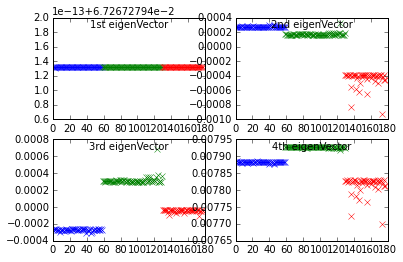

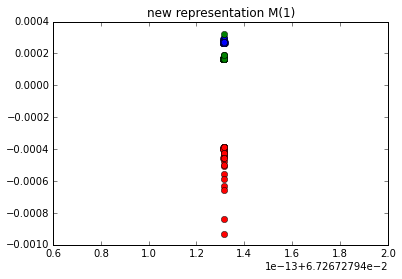

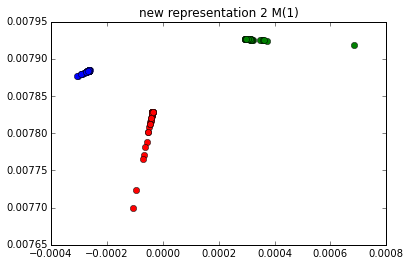

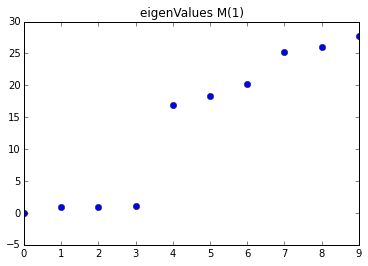

[ -4.42002802e-14   9.99451018e-01   9.99582024e-01   1.01373312e+00
   1.69836656e+01   1.83087574e+01   2.02316011e+01   2.51771686e+01
   2.59722298e+01   2.77316539e+01]
---------------------------------------- normalized2 -------------------------------------------------------------
P is:  [0.01694915254237288, 0.014084507042253521, 0.020833333333333332]


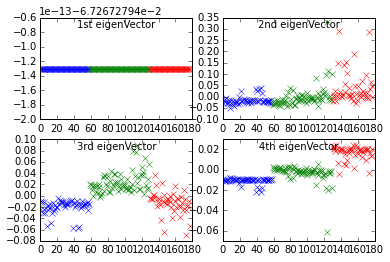

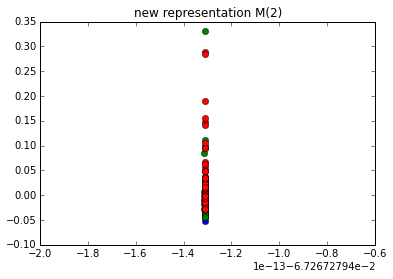

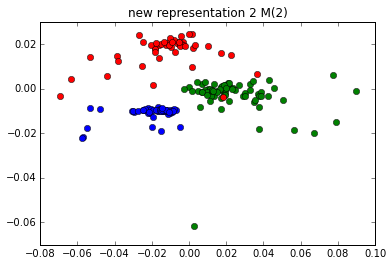

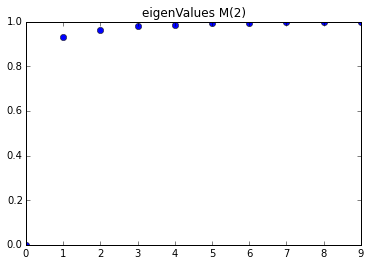

[  5.40570543e-16   9.31632168e-01   9.64437234e-01   9.79556109e-01
   9.85733695e-01   9.92230529e-01   9.95186993e-01   9.96123759e-01
   9.96463803e-01   9.98613107e-01]
---------------------------------------- normalized3 -------------------------------------------------------------
P is:  [0.01694915254237288, 0.014084507042253521, 0.020833333333333332]


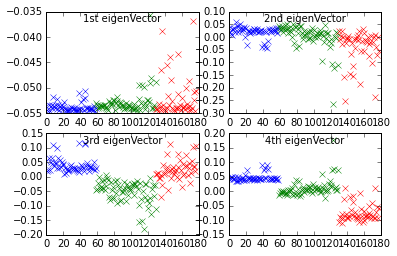

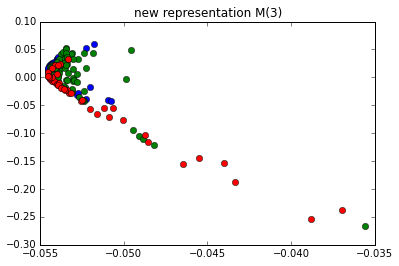

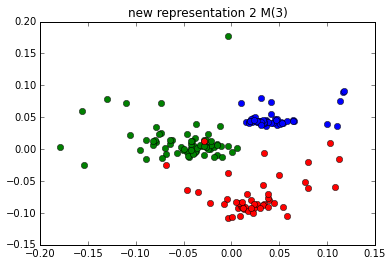

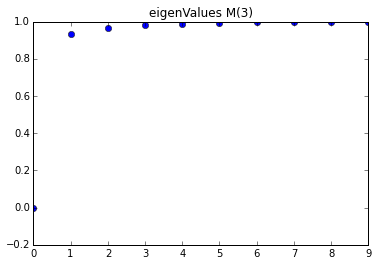

[ -8.88178420e-16   9.31632168e-01   9.64437234e-01   9.79556109e-01
   9.85733695e-01   9.92230529e-01   9.95186993e-01   9.96123759e-01
   9.96463803e-01   9.98613107e-01]


In [109]:
#prototyping
numP = 40

from sklearn.cluster import KMeans

centers = Prototyping(wineX,numP)

numS = wineX.shape[0]
N = numS + numP

print '---------------------------------------- Unnormalized -------------------------------------------------------------'
W,D,L = constructSupervised(wineX,numS,centers,numP,wineY)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],wineY,'M(1)')
print '---------------------------------------- normalized2 -------------------------------------------------------------'
W,D,L = constructSupervised(wineX,numS,centers,numP,wineY)
eigenValues,eigenVectors = normalized2(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],wineY,'M(2)')
print '---------------------------------------- normalized3 -------------------------------------------------------------'
W,D,L = constructSupervised(wineX,numS,centers,numP,wineY)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],wineY,'M(3)')

<b style="color:red">Glass Result</b>

---------------------------------------- Unnormalized -------------------------------------------------------------
P is:  [0.014285714285714285, 0.013157894736842105, 0.058823529411764705, 0.07692307692307693, 0.1111111111111111, 0.034482758620689655]


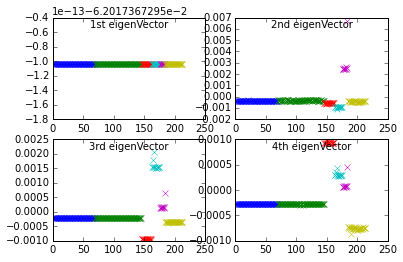

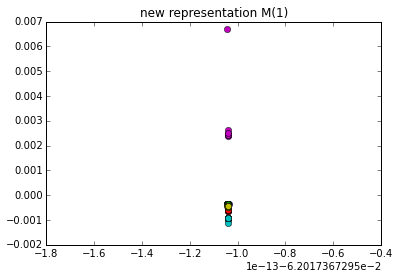

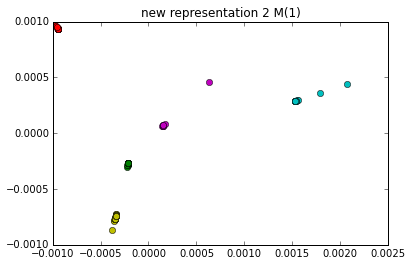

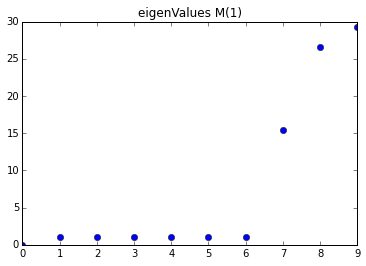

[  1.24616460e-13   9.96779033e-01   9.98072327e-01   9.98691289e-01
   9.99284572e-01   9.99628549e-01   1.02293791e+00   1.54945012e+01
   2.65624862e+01   2.93250320e+01]
---------------------------------------- normalized2 -------------------------------------------------------------
P is:  [0.014285714285714285, 0.013157894736842105, 0.058823529411764705, 0.07692307692307693, 0.1111111111111111, 0.034482758620689655]


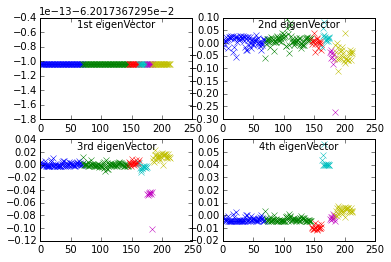

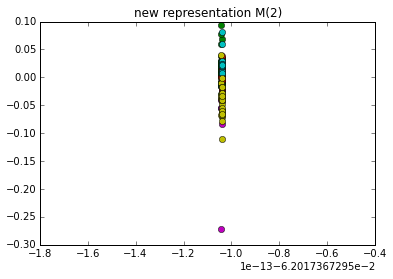

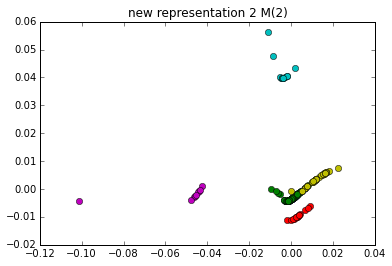

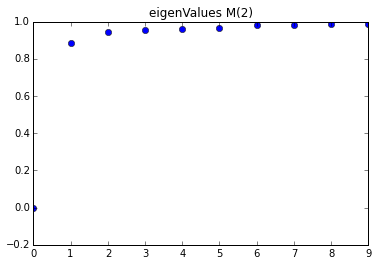

[ -3.28245620e-16   8.86240344e-01   9.46055730e-01   9.55827438e-01
   9.62065534e-01   9.67233831e-01   9.80431497e-01   9.81149112e-01
   9.87510453e-01   9.88623404e-01]
---------------------------------------- normalized3 -------------------------------------------------------------
P is:  [0.014285714285714285, 0.013157894736842105, 0.058823529411764705, 0.07692307692307693, 0.1111111111111111, 0.034482758620689655]


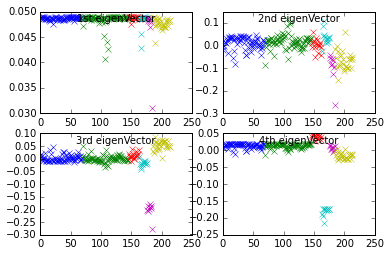

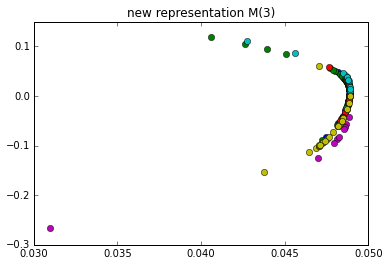

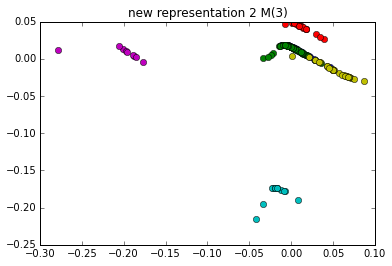

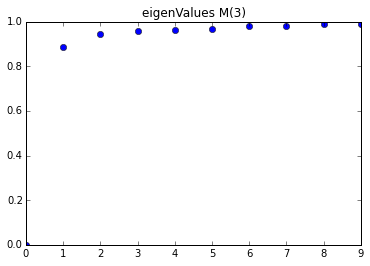

[  1.11022302e-16   8.86240344e-01   9.46055730e-01   9.55827438e-01
   9.62065534e-01   9.67233831e-01   9.80431497e-01   9.81149112e-01
   9.87510453e-01   9.88623404e-01]


In [110]:
#prototyping
numP = 40

from sklearn.cluster import KMeans

centers = Prototyping(glassX,numP)

numS = glassX.shape[0]
N = numS + numP

print '---------------------------------------- Unnormalized -------------------------------------------------------------'
W,D,L = constructSupervised(glassX,numS,centers,numP,glassY)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],glassY,'M(1)')
print '---------------------------------------- normalized2 -------------------------------------------------------------'
W,D,L = constructSupervised(glassX,numS,centers,numP,glassY)
eigenValues,eigenVectors = normalized2(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],glassY,'M(2)')
print '---------------------------------------- normalized3 -------------------------------------------------------------'
W,D,L = constructSupervised(glassX,numS,centers,numP,glassY)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],glassY,'M(3)')

<b style="color:red">sonar Result</b>

---------------------------------------- Unnormalized -------------------------------------------------------------
P is:  [0.009009009009009009, 0.010309278350515464]


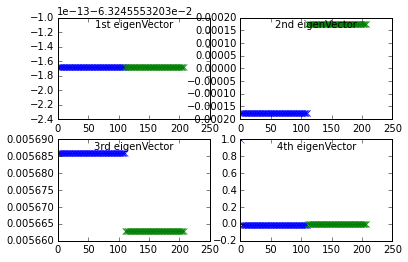

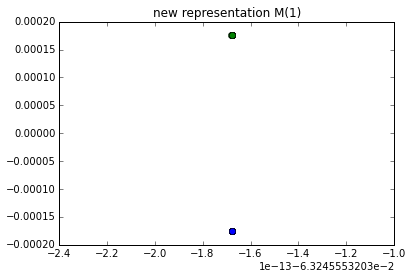

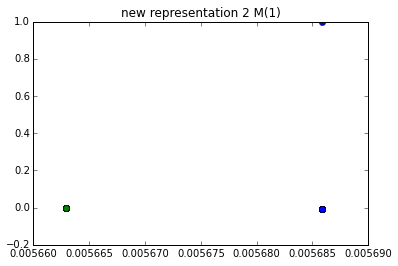

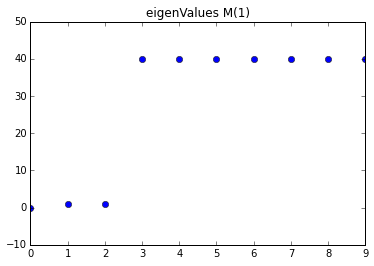

[ -8.88178420e-16   9.99752359e-01   1.00805709e+00   4.00085381e+01
   4.00089341e+01   4.00089542e+01   4.00089638e+01   4.00089690e+01
   4.00089815e+01   4.00089883e+01]
---------------------------------------- normalized2 -------------------------------------------------------------
P is:  [0.009009009009009009, 0.010309278350515464]


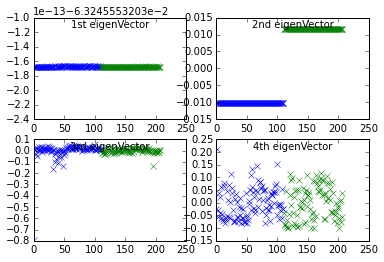

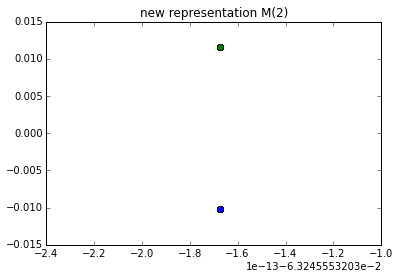

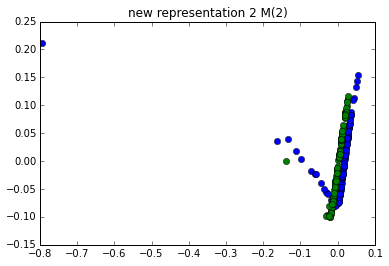

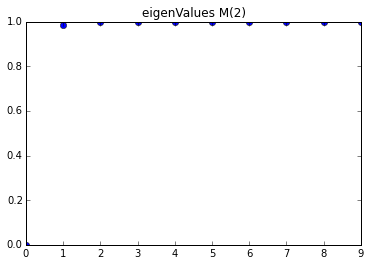

[  4.69252908e-16   9.84427155e-01   9.99999644e-01   9.99999917e-01
   9.99999985e-01   9.99999986e-01   9.99999995e-01   9.99999999e-01
   9.99999999e-01   1.00000000e+00]
---------------------------------------- normalized3 -------------------------------------------------------------
P is:  [0.009009009009009009, 0.010309278350515464]


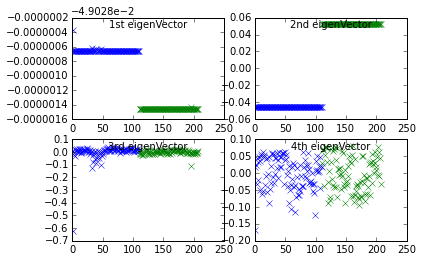

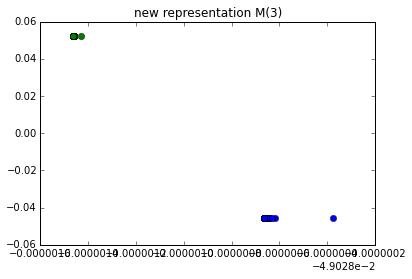

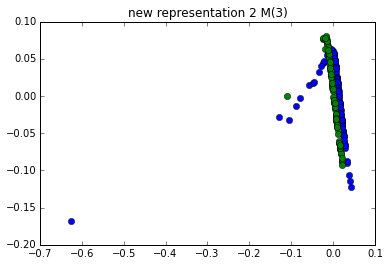

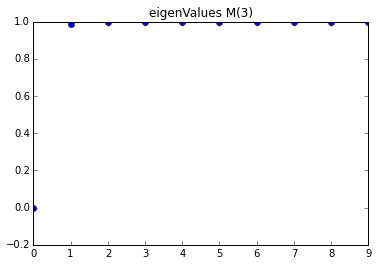

[ -2.22044605e-16   9.84427155e-01   9.99999644e-01   9.99999917e-01
   9.99999985e-01   9.99999986e-01   9.99999995e-01   9.99999999e-01
   9.99999999e-01   1.00000000e+00]


In [111]:
#prototyping
numP = 40

from sklearn.cluster import KMeans

centers = Prototyping(sonarX,numP)

numS = sonarX.shape[0]
N = numS + numP

print '---------------------------------------- Unnormalized -------------------------------------------------------------'
W,D,L = constructSupervised(sonarX,numS,centers,numP,sonarY)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],sonarY,'M(1)')
print '---------------------------------------- normalized2 -------------------------------------------------------------'
W,D,L = constructSupervised(sonarX,numS,centers,numP,sonarY)
eigenValues,eigenVectors = normalized2(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],sonarY,'M(2)')
print '---------------------------------------- normalized3 -------------------------------------------------------------'
W,D,L = constructSupervised(sonarX,numS,centers,numP,sonarY)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],sonarY,'M(3)')

<b style="color:red">Image Result</b>

---------------------------------------- Unnormalized -------------------------------------------------------------
P is:  [0.02, 0.02, 0.02]


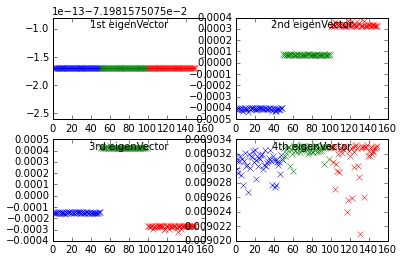

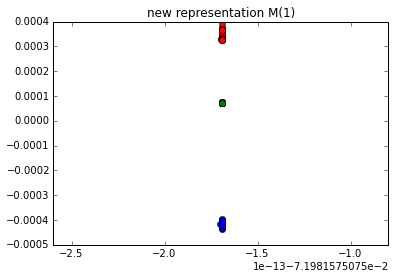

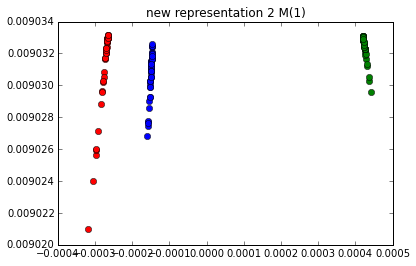

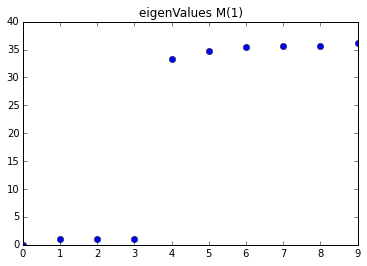

[  1.05054854e-14   9.99464377e-01   9.99473833e-01   1.01576604e+00
   3.33420514e+01   3.47053131e+01   3.55083605e+01   3.56611907e+01
   3.57073361e+01   3.61933205e+01]
---------------------------------------- normalized2 -------------------------------------------------------------
P is:  [0.02, 0.02, 0.02]


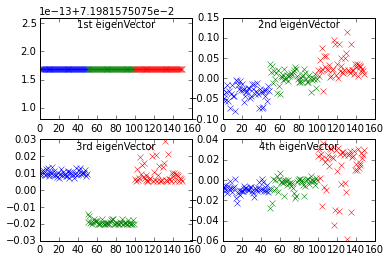

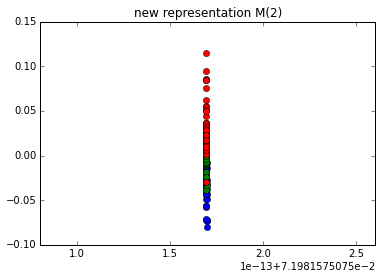

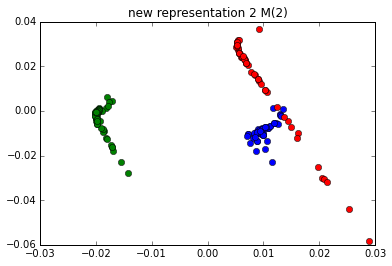

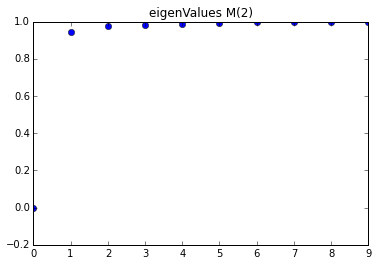

[ -1.90938675e-16   9.46609444e-01   9.76031839e-01   9.83727173e-01
   9.86650815e-01   9.94135594e-01   9.95882038e-01   9.97758832e-01
   9.98337080e-01   9.99031782e-01]
---------------------------------------- normalized3 -------------------------------------------------------------
P is:  [0.02, 0.02, 0.02]


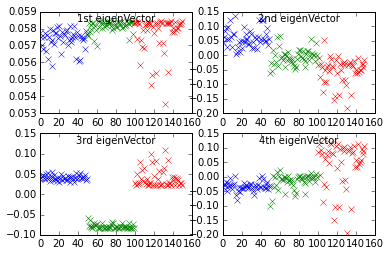

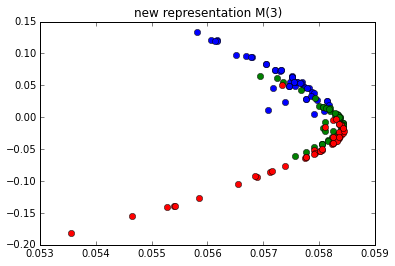

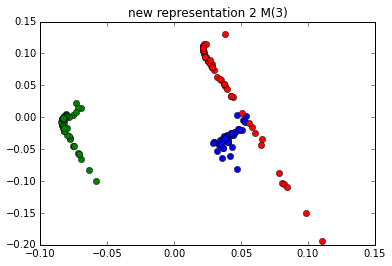

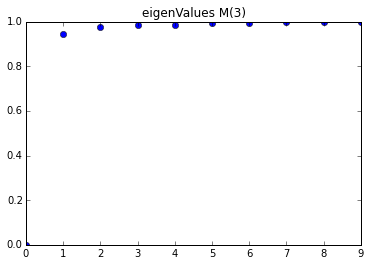

[  2.22044605e-16   9.46609444e-01   9.76031839e-01   9.83727173e-01
   9.86650815e-01   9.94135594e-01   9.95882038e-01   9.97758832e-01
   9.98337080e-01   9.99031782e-01]


In [114]:
#prototyping
numP = 40

from sklearn.cluster import KMeans

centers = Prototyping(irisX,numP)

numS = irisX.shape[0]
N = numS + numP

print '---------------------------------------- Unnormalized -------------------------------------------------------------'
W,D,L = constructSupervised(irisX,numS,centers,numP,irisY)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],irisY,'M(1)')
print '---------------------------------------- normalized2 -------------------------------------------------------------'
W,D,L = constructSupervised(irisX,numS,centers,numP,irisY)
eigenValues,eigenVectors = normalized2(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],irisY,'M(2)')
print '---------------------------------------- normalized3 -------------------------------------------------------------'
W,D,L = constructSupervised(irisX,numS,centers,numP,irisY)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],irisY,'M(3)')